Загрузка данных из wells_with_bht.xlsx...
Данные успешно загружены. Количество строк до очистки: 11201
Найденные колонки: ['Name', 'Api', 'Country', 'Status', 'Well Type', 'Latitude', 'Longitude', 'True Vertical Depth (ft)', 'True Vertical Depth (km)', 'Interpolated gradient', 'BHT', 'Suitable for ']
Проверка и очистка данных...
Количество строк для карты после очистки: 11201
Создание GeoDataFrame...
GeoDataFrame создан. Исходная CRS: EPSG:4326
Создание статической карты...
Перепроецирование в EPSG:3857 для basemap...
Перепроецирование успешно.
Нанесение данных на карту...
Данные нанесены.
Добавление basemap (может занять время)...
Basemap добавлен.
Добавление легенды (colorbar)...
Легенда добавлена.
Статическая карта успешно сохранена в файл: map_gradient_from_xlsx.png

Готово.


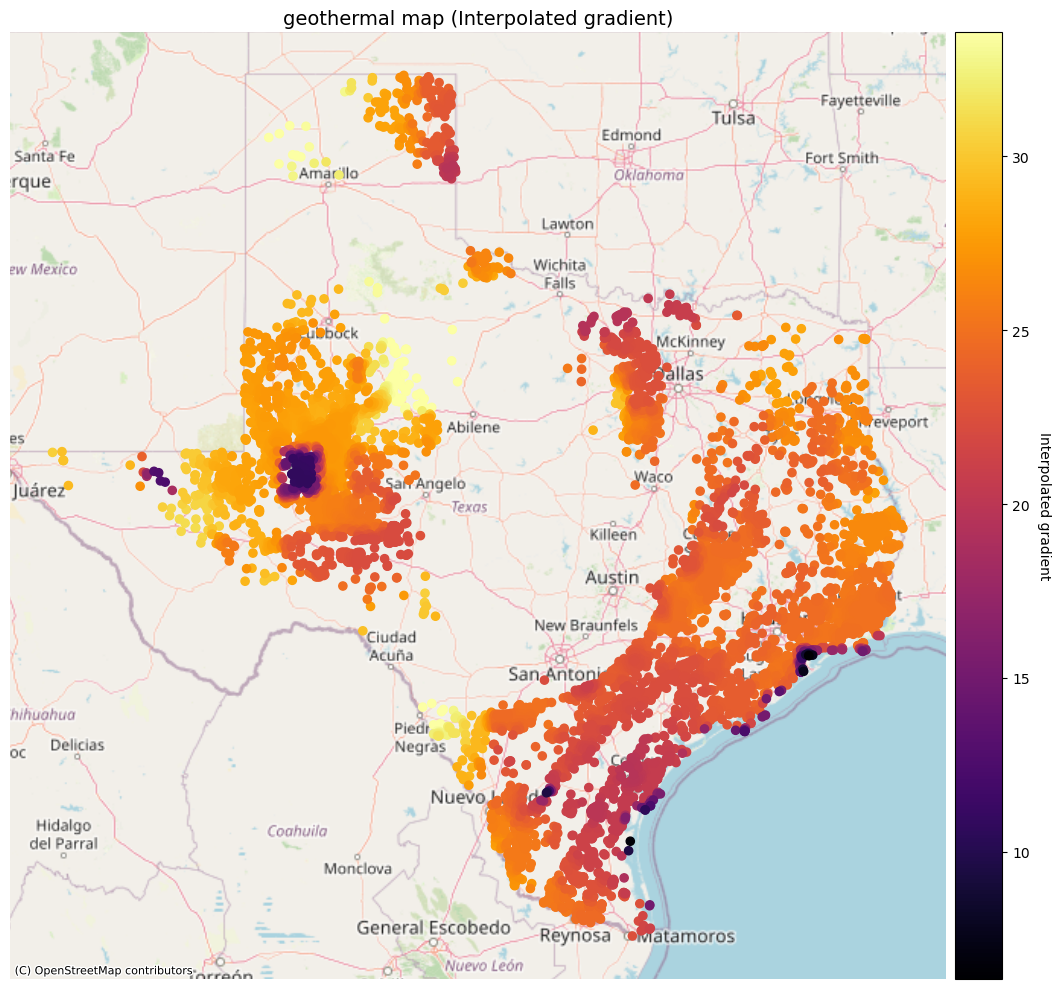

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # Для лучшего размещения легенды
import contextily as ctx # Для фоновой карты

# --- Константы ---
# !!! ИЗМЕНЕНО: Путь к новому файлу Excel !!!
EXCEL_FILE_PATH = 'wells_with_bht.xlsx'
# !!! ИЗМЕНЕНО: Имя выходного файла !!!
OUTPUT_IMAGE_FILE = 'map_gradient_from_xlsx.png'
# Ожидаемые имена колонок (ВАЖНО: проверьте, совпадают ли они с именами в вашем Excel файле!)
LAT_COL = 'Latitude'
LON_COL = 'Longitude'
VALUE_COL = 'Interpolated gradient' # Колонка для цвета точек
CRS_LATLON = 'EPSG:4326' # Исходная система координат (WGS84)
CRS_MERCATOR = 'EPSG:3857' # Система координат для contextily (Web Mercator)

# --- 1. Загрузка данных из Excel ---
print(f"Загрузка данных из {EXCEL_FILE_PATH}...")
try:
    # !!! ИЗМЕНЕНО: Используем read_excel !!!
    # Убедитесь, что у вас установлен openpyxl: pip install openpyxl
    df = pd.read_excel(EXCEL_FILE_PATH)
    print(f"Данные успешно загружены. Количество строк до очистки: {len(df)}")
    print(f"Найденные колонки: {list(df.columns)}")
except FileNotFoundError:
    print(f"Ошибка: Файл '{EXCEL_FILE_PATH}' не найден.")
    print("Пожалуйста, убедитесь, что файл находится в той же директории, что и скрипт, или укажите полный путь.")
    exit()
except ImportError:
    # Ошибка возникает, если не установлен openpyxl
    print("Ошибка: Для чтения Excel файлов (.xlsx) необходима библиотека 'openpyxl'.")
    print("Пожалуйста, установите ее: pip install openpyxl")
    exit()
except Exception as e:
    print(f"Произошла ошибка при чтении Excel файла: {e}")
    exit()

# --- 2. Подготовка и ОЧИСТКА данных ---
# Проверка наличия необходимых колонок
required_cols = [LAT_COL, LON_COL, VALUE_COL]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\n!!! Ошибка: В файле '{EXCEL_FILE_PATH}' отсутствуют необходимые колонки: {missing_cols}")
    print(f"    Ожидались колонки с именами: {required_cols}")
    print(f"    Найденные колонки: {list(df.columns)}")
    print("    Пожалуйста, переименуйте колонки в файле или измените константы LAT_COL, LON_COL, VALUE_COL в скрипте.")
    exit()

# Выбираем необходимые колонки
try:
    df_map = df[required_cols].copy()
except KeyError:
     # Эта ошибка не должна возникнуть из-за проверки выше, но оставляем на всякий случай
    print(f"Критическая ошибка: Не удалось выбрать колонки {required_cols}.")
    exit()

# Усиленная очистка (NaN, inf)
print("Проверка и очистка данных...")
for col in required_cols:
    # Преобразуем в числовой формат, ошибки станут NaN
    df_map[col] = pd.to_numeric(df_map[col], errors='coerce')
    # Заменяем бесконечные значения на NaN
    df_map.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаляем строки с любыми NaN
initial_rows = len(df_map)
df_map.dropna(subset=required_cols, inplace=True)
removed_rows = initial_rows - len(df_map)
if removed_rows > 0:
    print(f"Удалено {removed_rows} строк с отсутствующими, бесконечными или нечисловыми значениями.")

# Проверяем, остались ли данные после очистки
if df_map.empty:
    print("Ошибка: Нет данных для отображения после очистки.")
    exit()

# Финальное преобразование типов для надежности
try:
    df_map[LAT_COL] = df_map[LAT_COL].astype(float)
    df_map[LON_COL] = df_map[LON_COL].astype(float)
    df_map[VALUE_COL] = df_map[VALUE_COL].astype(float)
except ValueError as e:
    print(f"Критическая ошибка при финальном преобразовании данных в числовой формат: {e}")
    exit()

print(f"Количество строк для карты после очистки: {len(df_map)}")

# --- 3. Создание GeoDataFrame ---
# (Код без изменений)
print("Создание GeoDataFrame...")
try:
    # Создаем геометрию из колонок долготы и широты
    gdf = gpd.GeoDataFrame(
        df_map,
        geometry=gpd.points_from_xy(df_map[LON_COL], df_map[LAT_COL]),
        crs=CRS_LATLON # Устанавливаем исходную систему координат (WGS84)
    )
    print(f"GeoDataFrame создан. Исходная CRS: {gdf.crs}")
except Exception as e:
    print(f"Ошибка при создании GeoDataFrame: {e}")
    exit()


# --- 4. Создание статической карты ---
# (Код без изменений, кроме комментариев и print)
print("Создание статической карты...")
# Создаем фигуру и оси для графика
fig, ax = plt.subplots(1, 1, figsize=(12, 10)) # Размер можно настроить

# Перепроецируем в Web Mercator для добавления basemap
print(f"Перепроецирование в {CRS_MERCATOR} для basemap...")
try:
    gdf_mercator = gdf.to_crs(CRS_MERCATOR)
    print("Перепроецирование успешно.")
except Exception as e:
    print(f"Ошибка при перепроецировании CRS: {e}")
    print("Попытка построить карту без basemap...")
    gdf_mercator = gdf # Используем исходный gdf для построения без фона

# Построение точек, раскрашенных по градиенту
print("Нанесение данных на карту...")
# Выбираем цветовую карту: 'coolwarm' (синий->красный), 'viridis', 'plasma', 'inferno', 'magma'
cmap = 'inferno'
vmin = gdf_mercator[VALUE_COL].min() # Мин. значение для шкалы
vmax = gdf_mercator[VALUE_COL].max() # Макс. значение для шкалы

# Рисуем точки на осях 'ax'
plot = gdf_mercator.plot(
    column=VALUE_COL,   # Колонка для определения цвета
    cmap=cmap,          # Цветовая карта
    markersize=35,      # Размер маркеров
    alpha=1,          # Прозрачность маркеров (0=прозрачный, 1=непрозрачный)
    ax=ax,              # Оси для рисования
    legend=False,       # Отключаем стандартную легенду geopandas
    vmin=vmin,          # Минимальное значение для цветовой шкалы
    vmax=vmax-5           # Максимальное значение для цветовой шкалы
)
print("Данные нанесены.")

# Добавление basemap (если перепроецирование удалось)
if gdf_mercator.crs == CRS_MERCATOR:
    print("Добавление basemap (может занять время)...")
    try:
        # Добавляем фоновую карту OpenStreetMap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        # Другие варианты: ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron
        print("Basemap добавлен.")
    except Exception as e:
        print(f"Предупреждение: Не удалось добавить basemap: {e}. Карта будет без фона.")
else:
     print("Пропуск добавления basemap из-за проблем с CRS.")

# Настройка осей и заголовка
# !!! ИЗМЕНЕНО: Обновлен заголовок карты !!!
ax.set_title(f'geothermal map ({VALUE_COL})', fontsize=14)
ax.set_axis_off() # Отключаем оси X и Y

# Добавление colorbar (легенды) вручную для лучшего контроля
print("Добавление легенды (colorbar)...")
# Создаем объект для отображения цветов
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = [] # Небольшой трюк для ScalarMappable

# Создаем новые оси для colorbar справа от основной карты
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Добавляем colorbar на новые оси
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(f'{VALUE_COL}', rotation=270, labelpad=15) # Подписываем легенду
print("Легенда добавлена.")


# --- 5. Сохранение и отображение ---
plt.tight_layout() # Автоматически корректирует поля и расположение элементов
try:
    # !!! Используем новое имя файла !!!
    plt.savefig(OUTPUT_IMAGE_FILE, dpi=300, bbox_inches='tight') # dpi - разрешение, bbox_inches='tight' убирает лишние поля
    print(f"Статическая карта успешно сохранена в файл: {OUTPUT_IMAGE_FILE}")
except Exception as e:
    print(f"Ошибка при сохранении файла изображения: {e}")

# plt.show() # Раскомментируйте эту строку, если хотите, чтобы карта показалась в окне Python после выполнения скрипта

print("\nГотово.")
